In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser as ps
import datetime as dt
from workalendar.usa import UnitedStates
from workalendar.asia import SouthKorea, China, Japan
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.discrete.discrete_model as smd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats

In [41]:
df=pd.read_pickle('./df_with_features.zip',compression = 'zip')

In [42]:
df.head()

,game,console,publisher,total_shipped_in_mil,release_date,average_rating,release_year,near_us_holiday,near_sk_holiday,near_jp_holiday,near_cn_holiday,years_since_release,top_10_publisher
12973,Tom Clancy's Splinter Cell: Conviction,PC,Ubisoft,0.1,2010-04-27,8.0,2010,False,False,True,True,8.978082,False
13019,Blue Dragon: Awakened Shadow,DS,D3 Publisher,0.1,2010-05-18,5.7,2010,False,True,False,False,8.920548,False
13103,America's Next Top Model,DS,Conspiracy Entertainment,0.1,2010-06-01,3.5,2010,False,False,False,False,8.882192,False
13123,Disgaea Infinite,PSP,NIS America,0.1,2010-06-08,6.8,2010,False,False,False,False,8.863014,False
9572,"Blast Works: Build, Trade, Destroy",Wii,Majesco,0.1,2008-06-11,8.2,2008,False,False,False,False,10.854795,False


In [56]:
df_features = df.drop(columns = ['release_date','release_year','game','console','publisher'])

# Selects first column on left as the targeted and all columns on right as features
def patsy_string_from_df(df_features):
    patsy_string = df_features.columns[0] + " ~ "
    print('Predicted variable: ' + df_features.columns[0])
    for title in df_features.columns[1:]:
        patsy_string += title + " + "
    #remove last plus and spaces from string
    patsy_string=patsy_string[:-3]
    print("Patsy String: " +patsy_string)
    return patsy_string

#Uses above patsy string to make OLS model
def sm_OLS_model(df_features):
    # Takes in dataframe and makes model using first column as target and rest as features.
    y, X = patsy.dmatrices(patsy_string_from_df(df_features), data=df_features, return_type="dataframe")
    model = sm.OLS(y, X)

    # Fit your model to your training set
    fit = model.fit()
    return fit

# It looks like release date proximity to holidays doesn't really have an impact on total sales. Let's drop those
#f_features.drop(columns = ['near_sk_holiday','near_jp_holiday','near_cn_holiday'],inplace = True)
df_features.shape

(4000, 8)

In [57]:

# Drop outliers above 95%
outlier_cutoff = np.percentile(df_features['total_shipped_in_mil'],95)
outlier_cutoff = stats.iqr(df_features['total_shipped_in_mil'])*1.5
df_features =\
df_features.loc[df_features['total_shipped_in_mil'] < outlier_cutoff]

# No transformations model
fit1=sm_OLS_model(df_features)
fit1.summary()

Predicted variable: total_shipped_in_mil
Patsy String: total_shipped_in_mil ~ average_rating + near_us_holiday + near_sk_holiday + near_jp_holiday + near_cn_holiday + years_since_release + top_10_publisher


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     total_shipped_in_mil   R-squared:                       0.102
Model:                              OLS   Adj. R-squared:                  0.100
Method:                   Least Squares   F-statistic:                     51.28
Date:                  Thu, 18 Apr 2019   Prob (F-statistic):           1.49e-69
Time:                          14:57:41   Log-Likelihood:                -1310.8
No. Observations:                  3172   AIC:                             2638.
Df Residuals:                      3164   BIC:                             2686.
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0537      0.039     -1.377      0.169      -0.130       0.023
near_us_holiday[T.True]      0.0450      0.025      1.793      0.073      -0.004       0.094
near_sk_holiday[T.True]     -0.0256      0.021     -1.228      0.220      -0.067       0.015
near_jp_holiday[T.True]     -0.0079      0.019     -0.418      0.676      -0.045       0.029
near_cn_holiday[T.True]      0.0211      0.021      1.018      0.309      -0.020       0.062
top_10_publisher[T.True]     0.1150      0.013      8.610      0.000       0.089       0.141
average_rating               0.0772      0.005     15.670      0.000       0.068       0.087
years_since_release         -0.0021      0.001     -1.541      0.123      -0.005       0.001
==============================================================================
Omnibus:                      356.196   Durbin-Watson:                   0.201
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              485.890
Skew:                           0.952   Prob(JB):                    3.09e-106
Kurtosis:                       3.219   Cond. No.                         84.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
df_features.columns

Index(['total_shipped_in_mil', 'average_rating', 'near_us_holiday',
       'near_sk_holiday', 'near_jp_holiday', 'near_cn_holiday',
       'years_since_release', 'top_10_publisher'],
      dtype='object')

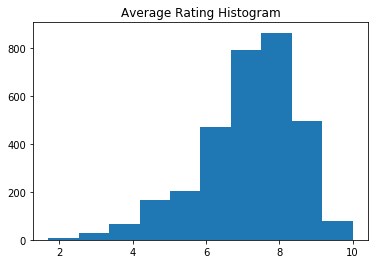

In [59]:
plt.hist(df_features['average_rating'])
plt.title('Average Rating Histogram');

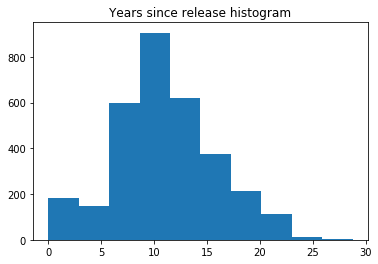

In [60]:
plt.hist(df_features['years_since_release'])
plt.title('Years since release histogram');

Lambda: 0.032122136911742795


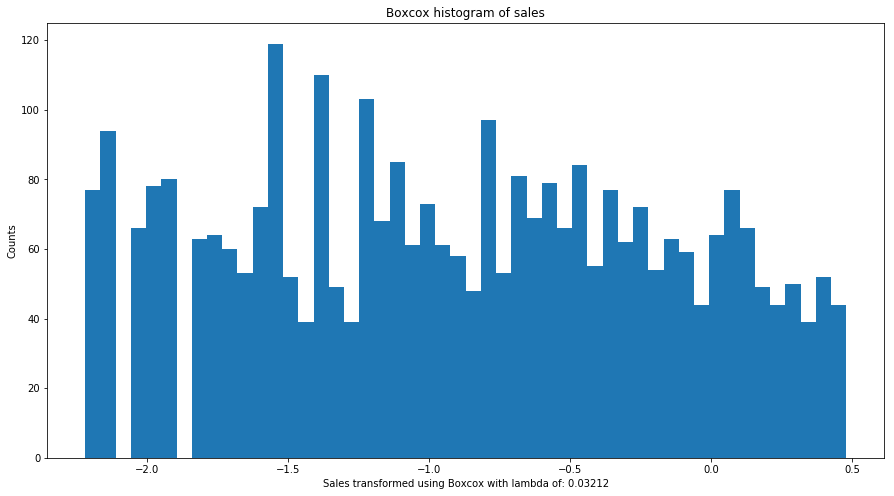

In [61]:
# Calculate scaling power using lambda
lamb=stats.boxcox_normmax(df_features['total_shipped_in_mil'],\
                          brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
y_t=(np.power(df_features['total_shipped_in_mil'],lamb)-1)/lamb


plt.figure(figsize=(15,8))
plt.xlabel("Sales transformed using Boxcox with lambda of: " + str(lamb.round(5)))
plt.ylabel("Counts")
plt.title('Boxcox histogram of sales');
plt.hist(y_t,bins = 50);

(array([1027.,  567.,  398.,  318.,  223.,  180.,  168.,  106.,   93.,
          92.]),
 array([0.1  , 0.251, 0.402, 0.553, 0.704, 0.855, 1.006, 1.157, 1.308,
        1.459, 1.61 ]),
 <a list of 10 Patch objects>)

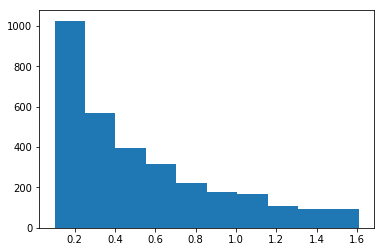

In [62]:
plt.hist(df_features['total_shipped_in_mil'])

In [63]:

# OLS model
df_features.insert(0,'total_shipped_in_mil_boxcox',y_t)
df_boxcox = df_features.drop(columns = 'total_shipped_in_mil')

In [64]:
df_boxcox.head()

,total_shipped_in_mil_boxcox,average_rating,near_us_holiday,near_sk_holiday,near_jp_holiday,near_cn_holiday,years_since_release,top_10_publisher
12973,-2.219492,8.0,False,False,True,True,8.978082,False
13019,-2.219492,5.7,False,True,False,False,8.920548,False
13103,-2.219492,3.5,False,False,False,False,8.882192,False
13123,-2.219492,6.8,False,False,False,False,8.863014,False
9572,-2.219492,8.2,False,False,False,False,10.854795,False


In [65]:
boxcox_fit = sm_OLS_model(df_boxcox)
boxcox_fit.summary()

Predicted variable: total_shipped_in_mil_boxcox
Patsy String: total_shipped_in_mil_boxcox ~ average_rating + near_us_holiday + near_sk_holiday + near_jp_holiday + near_cn_holiday + years_since_release + top_10_publisher


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     total_shipped_in_mil_boxcox   R-squared:                       0.119
Model:                                     OLS   Adj. R-squared:                  0.117
Method:                          Least Squares   F-statistic:                     61.09
Date:                         Thu, 18 Apr 2019   Prob (F-statistic):           1.19e-82
Time:                                 14:57:45   Log-Likelihood:                -3374.5
No. Observations:                         3172   AIC:                             6765.
Df Residuals:                             3164   BIC:                             6814.
Df Model:                                    7                                         
Covariance Type:                     nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.0604      0.075    -27.545      0.000      -2.207      -1.914
near_us_holiday[T.True]      0.0873      0.048      1.817      0.069      -0.007       0.182
near_sk_holiday[T.True]     -0.0356      0.040     -0.890      0.374      -0.114       0.043
near_jp_holiday[T.True]     -0.0306      0.036     -0.848      0.397      -0.101       0.040
near_cn_holiday[T.True]      0.0325      0.040      0.818      0.413      -0.045       0.110
top_10_publisher[T.True]     0.2593      0.026     10.126      0.000       0.209       0.310
average_rating               0.1566      0.009     16.585      0.000       0.138       0.175
years_since_release         -0.0064      0.003     -2.435      0.015      -0.012      -0.001
==============================================================================
Omnibus:                      294.994   Durbin-Watson:                   0.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.554
Skew:                           0.023   Prob(JB):                     3.58e-20
Kurtosis:                       2.178   Cond. No.                         84.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
df_features.iloc[:,1:].head()

,total_shipped_in_mil,average_rating,near_us_holiday,near_sk_holiday,near_jp_holiday,near_cn_holiday,years_since_release,top_10_publisher
12973,0.1,8.0,False,False,True,True,8.978082,False
13019,0.1,5.7,False,True,False,False,8.920548,False
13103,0.1,3.5,False,False,False,False,8.882192,False
13123,0.1,6.8,False,False,False,False,8.863014,False
9572,0.1,8.2,False,False,False,False,10.854795,False


In [67]:
df_boxcox.head()

,total_shipped_in_mil_boxcox,average_rating,near_us_holiday,near_sk_holiday,near_jp_holiday,near_cn_holiday,years_since_release,top_10_publisher
12973,-2.219492,8.0,False,False,True,True,8.978082,False
13019,-2.219492,5.7,False,True,False,False,8.920548,False
13103,-2.219492,3.5,False,False,False,False,8.882192,False
13123,-2.219492,6.8,False,False,False,False,8.863014,False
9572,-2.219492,8.2,False,False,False,False,10.854795,False


RMSE:  2.000363648184507
MAE:  1.7914240418739502
RMSE / max_val:  1.2425
MAE / max_val:  1.1127


Text(0.5, 0, 'test')

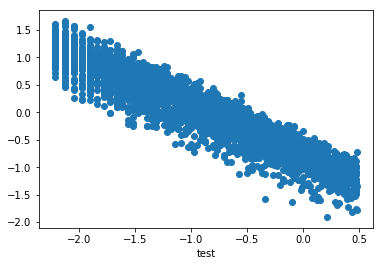

In [68]:
# Calculate root mean squared error
def transform_resids_back_to_correct_units(residual,lamb):
    return (lamb * residual + 1) ** (1/lamb)
    
#ypred = boxcox_fit.predict(df_boxcox.iloc[:,1:])
ypred = boxcox_fit.predict()
yval = df_boxcox['total_shipped_in_mil_boxcox'].values



residuals_squared = list()
residuals_abs = list()
residuals = list()
for i in range(0,len(yval)):
    residuals.append(ypred[i]-yval[i])
    residuals_squared.append((ypred[i]-yval[i])**2)
    residuals_abs.append(abs(ypred[i] - yval [i]))

rmse = transform_resids_back_to_correct_units(np.sqrt(sum(residuals_squared)/len(yval)),lamb)
mae = transform_resids_back_to_correct_units(sum(residuals_abs)/len(yval),lamb)

print("RMSE: ",rmse)
print("MAE: ",mae) 


max_val = df_features['total_shipped_in_mil'].max()
print("RMSE / max_val: " ,(rmse/max_val).round(4))
print("MAE / max_val: ",(mae/max_val).round(4))
plt.scatter(yval,residuals)
